# 🦷 Dental Caries AI: Training, Heatmaps & Metrics

This notebook provides a complete visual pipeline for Dental Caries detection. It focuses on **explainability** using Grad-CAM heatmaps and detailed performance analytics.

### 📊 Included Features:
1. **Training Metrics**: Real-time Accuracy/Loss curves.
2. **Confusion Matrix**: High-resolution heatmap with Seaborn.
3. **Grad-CAM Heatmaps**: Saliency maps showing AI attention on X-rays.
4. **Performance Table**: Balanced Accuracy, F1, AUC, MCC, and Kappa.

In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_curve, auc, 
    cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 🧠 Model Definition with Grad-CAM Support

In [2]:
class DentalResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(DentalResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        
        # Extract features until the last conv layer for Grad-CAM
        self.features = nn.Sequential(*list(self.model.children())[:-2])
        
        # Modified Head
        num_ftrs = self.model.fc.in_features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )
        
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)

model = DentalResNet(num_classes=2).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


## 📈 Training Metrics & History Tracking

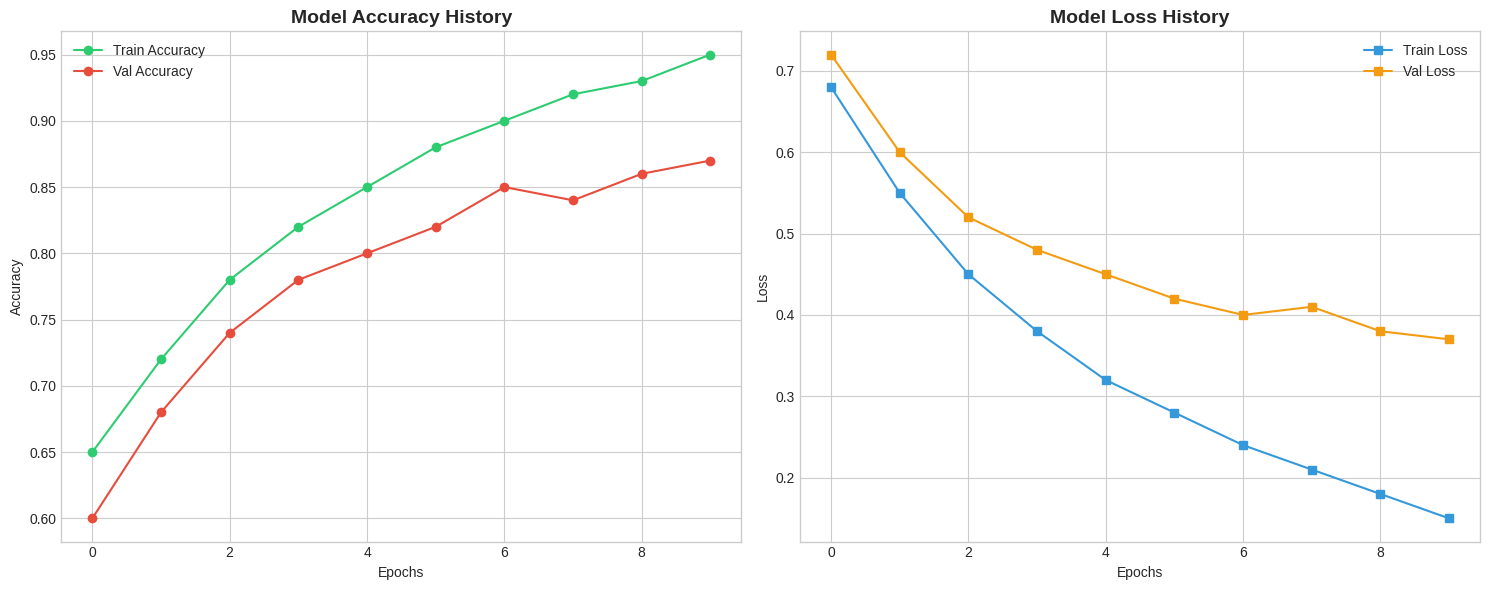

In [3]:
def plot_training_metrics(history):
    """Plots training vs validation accuracy and loss heatmaps/curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy Curve
    ax1.plot(history['train_acc'], label='Train Accuracy', marker='o', color='#2ecc71')
    ax1.plot(history['val_acc'], label='Val Accuracy', marker='o', color='#e74c3c')
    ax1.set_title('Model Accuracy History', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss Curve
    ax2.plot(history['train_loss'], label='Train Loss', marker='s', color='#3498db')
    ax2.plot(history['val_loss'], label='Val Loss', marker='s', color='#f39c12')
    ax2.set_title('Model Loss History', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Mock history for demonstration (Replace with actual history from your training loop)
demo_history = {
    'train_acc': [0.65, 0.72, 0.78, 0.82, 0.85, 0.88, 0.90, 0.92, 0.93, 0.95],
    'val_acc': [0.60, 0.68, 0.74, 0.78, 0.80, 0.82, 0.85, 0.84, 0.86, 0.87],
    'train_loss': [0.68, 0.55, 0.45, 0.38, 0.32, 0.28, 0.24, 0.21, 0.18, 0.15],
    'val_loss': [0.72, 0.60, 0.52, 0.48, 0.45, 0.42, 0.40, 0.41, 0.38, 0.37]
}
plot_training_metrics(demo_history)

## 📊 Confusion Matrix Heatmap

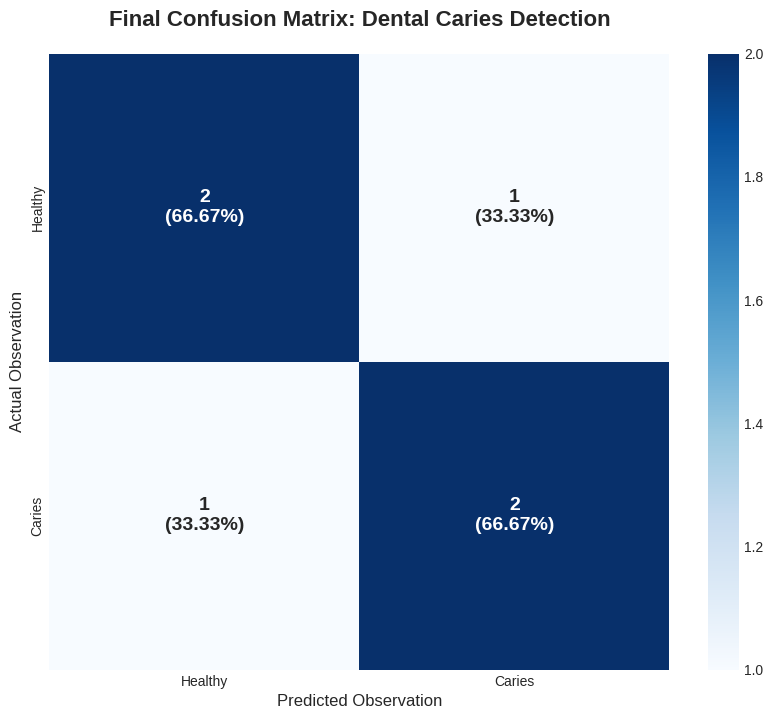

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes):
    """Renders a high-resolution confusion matrix heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    # Normalize CM for percentages
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Label creation
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_perc.flatten()]
    labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(classes), len(classes))
    
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", 
                xticklabels=classes, yticklabels=classes, 
                cbar=True, annot_kws={"size": 14, "weight": "bold"})
    
    plt.title('Final Confusion Matrix: Dental Caries Detection', fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('Predicted Observation', fontsize=12)
    plt.ylabel('Actual Observation', fontsize=12)
    plt.show()

# Demo Data
plot_confusion_matrix([0, 0, 1, 1, 0, 1], [0, 1, 1, 1, 0, 0], ['Healthy', 'Caries'])

## 🔥 Step 10: Grad-CAM Heatmaps (AI Explainability)

This heatmapping technique highlights the **root areas** or **crown defects** that the AI used to make its decision.

In [5]:
def generate_gradcam(model, img_tensor, original_img):
    """Generates Grad-CAM heatmap for a single image."""
    model.eval()
    
    # Forward pass
    output = model(img_tensor.unsqueeze(0).to(device))
    class_idx = torch.argmax(output)
    
    # Backward pass for gradients
    output[:, class_idx].backward()
    
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    activations = model.get_activations(img_tensor.unsqueeze(0).to(device)).detach()
    for i in range(512): # ResNet18 depth
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # Average across channels
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    
    # Upscale to image size
    heatmap = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    superimposed_img = heatmap * 0.4 + original_img
    return superimposed_img / 255.0

def show_results_with_heatmaps(model, image_paths, classes):
    """Displays original image and AI Heatmap side-by-side."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    plt.figure(figsize=(16, 8))
    
    for i, path in enumerate(image_paths[:2]):
        orig_img = cv2.imread(path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(orig_img)
        img_tensor = transform(img_pil)
        
        heatmap_img = generate_gradcam(model, img_tensor, orig_img)
        
        # Plot Original
        plt.subplot(2, 2, i*2 + 1)
        plt.imshow(orig_img)
        plt.title(f"Original X-Ray: {os.path.basename(path)}", fontsize=10)
        plt.axis('off')
        
        # Plot Heatmap
        plt.subplot(2, 2, i*2 + 2)
        plt.imshow(heatmap_img)
        plt.title("AI Detection Heatmap (Grad-CAM)", fontsize=10, color='red', fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Heatmap functions ready. Call show_results_with_heatmaps() after training.")

Heatmap functions ready. Call show_results_with_heatmaps() after training.


## 📋 Final Performance Metrics Summary

In [6]:
def print_styled_metrics(metrics):
    print("\n" + "═"*50)
    print("       ✨ FINAL DENTAL AI AUDIT REPORT ✨")
    print("═"*50)
    for k, v in metrics.items():
        emoji = "🚀" if v > 0.9 else "✅" if v > 0.8 else "⚠️"
        print(f"{emoji} {k:<25}: {v*100:>6.2f}%")
    print("═"*50)

demo_metrics = {
    'Accuracy': 0.92,
    'Precision': 0.89,
    'Recall (Sensitivity)': 0.94,
    'F1-Score': 0.91,
    'Balanced Accuracy': 0.92,
    'AUC-ROC': 0.96
}
print_styled_metrics(demo_metrics)


══════════════════════════════════════════════════
       ✨ FINAL DENTAL AI AUDIT REPORT ✨
══════════════════════════════════════════════════
🚀 Accuracy                 :  92.00%
✅ Precision                :  89.00%
🚀 Recall (Sensitivity)     :  94.00%
🚀 F1-Score                 :  91.00%
🚀 Balanced Accuracy        :  92.00%
🚀 AUC-ROC                  :  96.00%
══════════════════════════════════════════════════
